# Modelling Zero Curve for Treasury Bonds

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [311]:
df_bonds = pd.read_excel("bonds_data.xlsx")

In [312]:
df_bonds['Compound Frequency per Year (m)'] = 1/df_bonds['Time to Maturity (Years)']

In [313]:
df_bonds['number_of_cashflows'] = np.where(df_bonds['Annual Coupon (USD)'] == 0, 1, df_bonds['Time to Maturity (Years)']/0.5)

# 1. Calculating the Zero Rates (a.a.) for Zero Coupon Bonds

In [314]:
def convertMCompoundedToContionousCompounded(Rm, m):
    return m*np.log(1+(Rm/m))

In [315]:
df_bonds['Zero Rates (m-compounded) per Year'] = np.where(df_bonds['Annual Coupon (USD)'] == 0, 
                                                ((df_bonds['Bond Principal (USD)'] - df_bonds['Bond Price (USD)'])/df_bonds['Bond Price (USD)'])*df_bonds['Compound Frequency per Year (m)'],
                                                 0
                                                )

In [316]:
df_bonds['Zero Rates (Continous Compounded) per Year'] = df_bonds.apply(lambda x: 
    convertMCompoundedToContionousCompounded(x['Zero Rates (m-compounded) per Year'], x['Compound Frequency per Year (m)']), 
                                                                        axis=1)

In [317]:
df_bonds

,Bond Principal (USD),Time to Maturity (Years),Annual Coupon (USD),Bond Price (USD),Compound Frequency per Year (m),number_of_cashflows,Zero Rates (m-compounded) per Year,Zero Rates (Continous Compounded) per Year
0,100,0.5,0,94.9,2.000000,1.0,0.107482,0.104693
1,100,1.0,0,90.0,1.000000,1.0,0.111111,0.105361
2,100,1.5,8,96.0,0.666667,3.0,0.000000,0.000000
3,100,2.0,12,101.6,0.500000,4.0,0.000000,0.000000


In [318]:
for idx, row in df_bonds.iterrows():
    if row['Annual Coupon (USD)'] == 0.0:
        df_bonds.loc[idx, 'Zero Rates (Continous Compounded) per Year'] = row['Zero Rates (Continous Compounded) per Year']
    else:
        df_bonds_filt = df_bonds[df_bonds['Time to Maturity (Years)'] < row['Time to Maturity (Years)']]
        
        semiannual_coupon = row['Annual Coupon (USD)']/2
        bond_principal = row['Bond Principal (USD)']
        bond_price = row['Bond Price (USD)']
        time_to_maturity = row['Time to Maturity (Years)']
        
        list_cashflows = []
        for _maturity in df_bonds_filt['Time to Maturity (Years)'].tolist():
            zero_rate_cc = df_bonds_filt[df_bonds_filt['Time to Maturity (Years)'] == _maturity]['Zero Rates (Continous Compounded) per Year'].iloc[0]
            list_cashflows.append(semiannual_coupon*np.e**(-zero_rate_cc*_maturity))
        
        sum_cash_flows = sum(list_cashflows)
        log_arg = (bond_price - sum_cash_flows)/(bond_principal+semiannual_coupon)
        zero_rate = - np.log(log_arg)/time_to_maturity
        
        df_bonds.loc[idx, 'Zero Rates (Continous Compounded) per Year'] = zero_rate
        


In [319]:
df_bonds

,Bond Principal (USD),Time to Maturity (Years),Annual Coupon (USD),Bond Price (USD),Compound Frequency per Year (m),number_of_cashflows,Zero Rates (m-compounded) per Year,Zero Rates (Continous Compounded) per Year
0,100,0.5,0,94.9,2.000000,1.0,0.107482,0.104693
1,100,1.0,0,90.0,1.000000,1.0,0.111111,0.105361
2,100,1.5,8,96.0,0.666667,3.0,0.000000,0.106809
3,100,2.0,12,101.6,0.500000,4.0,0.000000,0.108080


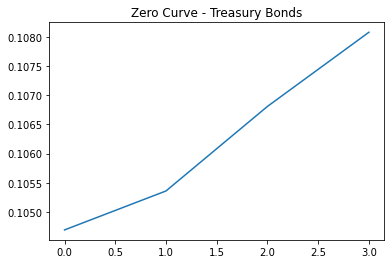

In [323]:
plt.plot(df_bonds['Zero Rates (Continous Compounded) per Year']);
plt.title("Zero Curve - Treasury Bonds");